In [1]:
# Names
# Sadman Sakib
# Anshuman Senapati

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/11 05:22:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
!rm -r data

!wget https://pages.cs.wisc.edu/~harter/cs544/data/hdma-wi-2021.zip
!wget https://pages.cs.wisc.edu/~harter/cs544/data/arid2017_to_lei_xref_csv.zip
!wget https://pages.cs.wisc.edu/~harter/cs544/data/code_sheets.zip
!mkdir -p nb/data
!unzip -o hdma-wi-2021.zip -d data/
!unzip -o arid2017_to_lei_xref_csv.zip -d data
!unzip -o code_sheets.zip -d data

--2023-11-11 05:23:09--  https://pages.cs.wisc.edu/~harter/cs544/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip.1’

hdma-wi-2021.zip.1  100%[===================>]  20.50M  4.31MB/s    in 4.7s    

2023-11-11 05:23:14 (4.36 MB/s) - ‘hdma-wi-2021.zip.1’ saved [21494278/21494278]

--2023-11-11 05:23:14--  https://pages.cs.wisc.edu/~harter/cs544/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip.1’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.09s   

2023-11-11 05:23:15 (1.47

In [4]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [5]:
#q1: how many banks contain the word "first" in their name, ignoring case? Use an RDD to answer. 
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)
first = banks_df.rdd.filter(lambda row: "first" in row["respondent_name"].lower()) 
first.count()

23/11/11 05:24:26 ERROR TaskSchedulerImpl: Lost executor 0 on 172.20.0.5: Command exited with code 134
23/11/11 05:24:26 WARN TaskSetManager: Lost task 0.0 in stage 0.0 (TID 0) (172.20.0.5 executor 0): ExecutorLostFailure (executor 0 exited caused by one of the running tasks) Reason: Command exited with code 134


525

In [6]:
#q2: how many banks contain the word "first" in their name, ignoring case? Use a DataFrame to answer.
from pyspark.sql.functions import lower
banks_df.filter(lower(banks_df["respondent_name"]).contains("first")).count()

525

In [7]:
#q3: how many banks contain the word "first" in their name, ignoring case? Use Spark SQL to answer.
banks_df.write.saveAsTable("banks", mode="overwrite")
spark.sql("select count(*) as count_first from banks where respondent_name ilike '%first%'").toPandas()["count_first"][0]

23/11/11 05:25:13 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/11 05:25:13 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/11 05:25:24 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/11 05:25:24 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.2
23/11/11 05:25:27 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/11 05:25:29 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/11/11 05:25:33 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/banks; Force to delete it.
23/11/11 05:25:33 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/banks
23/11/11 05:25:41 WARN SessionState

525

In [8]:
#q4: what tables are in our warehouse?
loans_df = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

names = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]
for name in names:
    df = spark.read.csv("hdfs://nn:9000/{}.csv".format(name), header=True, inferSchema=True)
    df.createOrReplaceTempView(name)
tables = spark.sql("SHOW TABLES").collect()
q4 = {table["tableName"]:table["isTemporary"] for table in tables}
q4

23/11/11 05:26:18 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
23/11/11 05:26:18 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/loans; Force to delete it.
23/11/11 05:26:18 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/loans
23/11/11 05:26:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
#q5: how many loan applications has the bank "University of Wisconsin Credit Union" received in 2020 in this dataset?
df = spark.sql("""
SELECT * 
FROM (
SELECT banks.respondent_name, COUNT(*) as count 
FROM banks
INNER JOIN loans ON loans.lei = banks.lei_2020
GROUP BY banks.respondent_name
)
WHERE respondent_name = "University of Wisconsin Credit Union"
""")
df.toPandas()['count'][0]

19739

In [10]:
#q6: what does .explain("formatted") tell us about how Spark executes Q5?
exp = spark.sql("""
SELECT * 
FROM (
SELECT banks.respondent_name, COUNT(*) as count 
FROM banks
INNER JOIN loans ON loans.lei = banks.lei_2020
GROUP BY banks.respondent_name
)
WHERE respondent_name = "University of Wisconsin Credit Union"
""").explain("formatted")

# In BroadcastExchange, banks table is sent to every executor
# Yes, the plan involves HashAggregates two times - count and partial_count 

== Physical Plan ==
AdaptiveSparkPlan (11)
+- HashAggregate (10)
   +- Exchange (9)
      +- HashAggregate (8)
         +- Project (7)
            +- BroadcastHashJoin Inner BuildLeft (6)
               :- BroadcastExchange (3)
               :  +- Filter (2)
               :     +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (5)
                  +- Scan parquet spark_catalog.default.loans (4)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#66, lei_2020#70]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#66, lei_2020#70]
Condition : ((isnotnull(respondent_name#66) AND (respondent_name#66 = University of Wisconsin Credit Union)) AND isnotnull(lei_2020#70))

(3) BroadcastExc

In [11]:
# Assume loans have interest_rate column
spark.sql("""
CREATE  OR REPLACE TEMPORARY VIEW loans_bank
AS
SELECT loans.*, banks.respondent_name 
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
""")

DataFrame[]

In [12]:
spark.sql("""
SELECT * FROM loans_bank
WHERE respondent_name LIKE '%Fargo%'
""").limit(10).toPandas()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,respondent_name
0,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079004100,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,2415,92.96,84400,58,434,1044,66,"Wells Fargo Bank, National Association"
1,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079140201,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,5130,14.27,84400,101,1427,1953,60,"Wells Fargo Bank, National Association"
2,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079185200,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,5006,19.82,84400,92,1283,1697,58,"Wells Fargo Bank, National Association"
3,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079185200,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,5006,19.82,84400,92,1283,1697,58,"Wells Fargo Bank, National Association"
4,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079019000,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,4867,31.50,84400,86,1316,1711,63,"Wells Fargo Bank, National Association"
5,2021,KB1H1DSPRFMYMCUFXT09,31540,WI,55025,55025002602,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,6082,35.14,99000,83,1073,1320,32,"Wells Fargo Bank, National Association"
6,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079140201,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,5130,14.27,84400,101,1427,1953,60,"Wells Fargo Bank, National Association"
7,2021,KB1H1DSPRFMYMCUFXT09,33340,WI,55079,55079006000,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,2699,95.48,84400,41,239,1035,76,"Wells Fargo Bank, National Association"
8,2021,KB1H1DSPRFMYMCUFXT09,99999,WI,55071,55071005200,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,4498,3.07,69600,104,1478,1903,52,"Wells Fargo Bank, National Association"
9,2021,KB1H1DSPRFMYMCUFXT09,99999,WI,55071,55071000500,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,2650,23.96,69600,70,715,1277,76,"Wells Fargo Bank, National Association"


In [13]:
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW top_10_counties
AS
SELECT county_code, COUNT(*) AS num_applications, AVG(interest_rate) AS avg_interest_rate
FROM loans_bank
WHERE respondent_name LIKE 'Wells Fargo%'
GROUP BY county_code
ORDER BY num_applications DESC
LIMIT 10;
""")

spark.sql("""
SELECT * FROM top_10_counties
""").toPandas()

,county_code,num_applications,avg_interest_rate
0,55079,2164,3.117347
1,55133,1832,2.875823
2,55131,748,2.851009
3,55025,729,2.890675
4,55009,663,3.010949
5,55101,537,3.099784
6,55087,513,2.979662
7,55139,402,3.028476
8,55089,389,2.867377
9,55117,307,2.995511


In [14]:
counties_int = spark.sql("""
SELECT NAME, avg_interest_rate
FROM
(SELECT counties.NAME, top_10_counties.avg_interest_rate, top_10_counties.num_applications
FROM top_10_counties
JOIN counties ON top_10_counties.county_code = counties.STATE * 1000 + counties.COUNTY)
ORDER BY num_applications DESC
""")

In [15]:
#q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?
counties_int.toPandas()
counties_int_dict = counties_int.rdd.map(lambda row: (row.NAME, row.avg_interest_rate)).collectAsMap()
counties_int_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

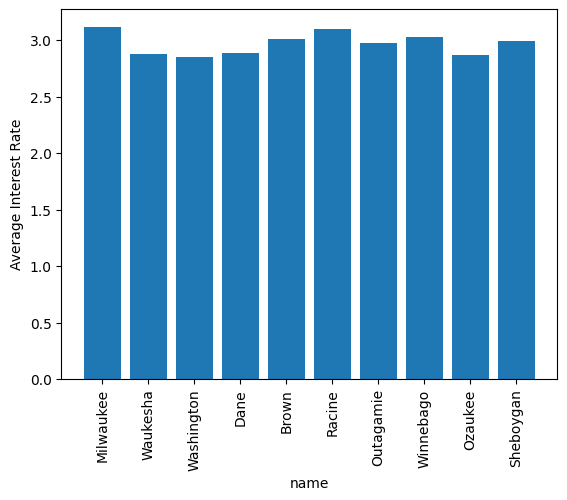

In [16]:
import matplotlib.pyplot as plt

plt.bar(range(1, 11), counties_int.toPandas()['avg_interest_rate'])
plt.xticks(range(1, 11), counties_int.toPandas()['NAME'].values, rotation=90)
plt.xlabel('name')
plt.ylabel('Average Interest Rate')
plt.show()

In [17]:
#q8: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?
spark.sql("""
SELECT county_code, MEAN(tract_median_age_of_housing_units), COUNT(*) as count
FROM loans
GROUP BY county_code 
""").explain()

spark.sql("""
SELECT lei, MEAN(tract_median_age_of_housing_units), COUNT(*) as count
FROM loans
GROUP BY lei 
""").explain()

# We bucketed loans table with county_code. So, when grouping by county_code no network i/o happens. However, when grouping by other colums
# such as lei, network io can happen. This is evident in the presence of 'Exchange hashpartitioning' in lei group_by explain() output,
# and it is absent in county_code explain output. 

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#992], functions=[mean(tract_median_age_of_housing_units#1086), count(1)])
   +- HashAggregate(keys=[county_code#992], functions=[partial_mean(tract_median_age_of_housing_units#1086), partial_count(1)])
      +- FileScan parquet spark_catalog.default.loans[county_code#992,tract_median_age_of_housing_units#1086] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,tract_median_age_of_housing_units:int>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#989], functions=[mean(tract_median_age_of_housing_units#1086), count(1)])
   +- Exchange hashpartitioning(lei#989, 200), ENSURE_REQUIREMENTS, [plan_id=1213]
      +- HashAggregate(keys=[lei#989], functions=[partial_

In [18]:
#q9: How many loans are approved (approval = 1) in the train DataFrame?
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when, lit
df = spark.sql("select loan_amount, income, interest_rate, action_taken as approval from loans")

df = df.withColumn('approval', df.approval==1)
columns_to_cast = ["approval", "income", "interest_rate"]
for column in columns_to_cast:
    df = df.withColumn(column, df[column].cast(DoubleType()))
df = df.fillna(0)
train, test = df.randomSplit([0.8, 0.2], seed=41) 
train.rdd.cache()
train[train['approval']==1].count()

242868

In [19]:
#q10: What is the accuracy of the decision tree classifier of depth 5 on the test dataset?
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.pipeline import Pipeline, PipelineModel

# pipeline
va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="approval", maxDepth=5)
pipe = Pipeline(stages=[va, dt])

# training
model = pipe.fit(train)
model.write().overwrite().save("hdfs://nn:9000/model")

# testing
model = PipelineModel.load("hdfs://nn:9000/model")
# print('depth', model.stages[1].depth)
preds = model.transform(test)
acc = preds[preds['approval']==preds['prediction']].count() / preds.count()
acc

0.8939992653524639